In [ ]:
# Install required packages
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

import findspark
findspark.init()

# Initialize Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import numpy as np

spark = SparkSession.builder \
    .appName("MovieRecommendationSystem") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [ ]:
# Load the dataset
ratings_df = spark.read.csv(
    "/content/ratings.csv",
    header=True,
    inferSchema=True
)

movies_df = spark.read.csv(
    "/content/movies.csv",
    header=True,
    inferSchema=True
)

In [ ]:
print("Missing values in ratings:")
ratings_df.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings_df.columns]).show()

print("\nMissing values in movies:")
movies_df.select([count(when(col(c).isNull(), c)).alias(c) for c in movies_df.columns]).show()

# Check data types
print("\nData types before conversion:")
ratings_df.dtypes

# Convert timestamp
from pyspark.sql.functions import from_unixtime

ratings_df = ratings_df.withColumn(
    "timestamp_formatted",
    from_unixtime(col("timestamp")).cast("timestamp")
)

# Remove duplicate ratings
print(f"Ratings before removing duplicates: {ratings_df.count():,}")
ratings_df = ratings_df.dropDuplicates(["userId", "movieId"])
print(f"Ratings after removing duplicates: {ratings_df.count():,}")

# Filter out movies
rating_counts = ratings_df.groupBy("movieId").count()
movies_with_enough_ratings = rating_counts.filter(col("count") >= 5)

print(f"\nMovies with at least 5 ratings: {movies_with_enough_ratings.count():,}")

# Join to filter ratings
ratings_df = ratings_df.join(
    movies_with_enough_ratings.select("movieId"),
    "movieId",
    "inner"
)

Missing values in ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+


Missing values in movies:
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+


Data types before conversion:
Ratings before removing duplicates: 25,000,095
Ratings after removing duplicates: 25,000,095

Movies with at least 5 ratings: 32,720


Rating Statistics:
+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          24945870|
|   mean| 3.535054580176999|
| stddev|1.0602721018272363|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+


Rating Distribution:
+------+-------+
|rating|  count|
+------+-------+
|   0.5| 390176|
|   1.0| 774446|
|   1.5| 397183|
|   2.0|1636050|
|   2.5|1255773|
|   3.0|4884498|
|   3.5|3167776|
|   4.0|6633261|
|   4.5|2198236|
|   5.0|3608471|
+------+-------+



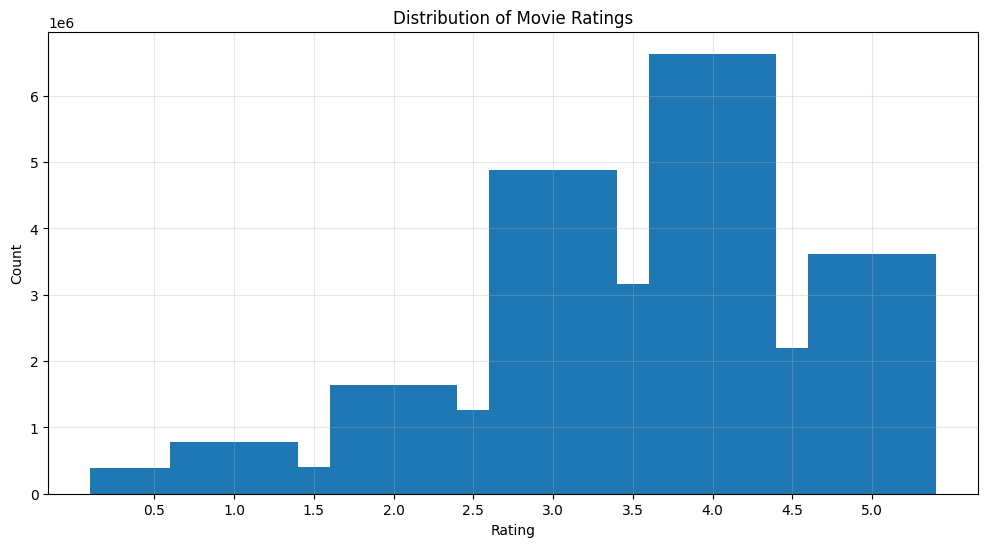


Top 10 Most Rated Movies:
+-------+-----------------------------------------+-----------+------------------+
|movieId|title                                    |num_ratings|avg_rating        |
+-------+-----------------------------------------+-----------+------------------+
|356    |Forrest Gump (1994)                      |81491      |4.048011436845787 |
|318    |Shawshank Redemption, The (1994)         |81482      |4.413576004516335 |
|296    |Pulp Fiction (1994)                      |79672      |4.188912039361382 |
|593    |Silence of the Lambs, The (1991)         |74127      |4.151341616415071 |
|2571   |Matrix, The (1999)                       |72674      |4.154099127610975 |
|260    |Star Wars: Episode IV - A New Hope (1977)|68717      |4.120188599618726 |
|480    |Jurassic Park (1993)                     |64144      |3.6791749812920926|
|527    |Schindler's List (1993)                  |60411      |4.247579083279535 |
|110    |Braveheart (1995)                        |59184    

In [ ]:
# Statistics
print("Rating Statistics:")
ratings_df.select("rating").describe().show()

# Distribution of ratings
print("\nRating Distribution:")
ratings_df.groupBy("rating").count().orderBy("rating").show(20)

# Visualize rating distribution
import matplotlib.pyplot as plt
import seaborn as sns

rating_dist = ratings_df.groupBy("rating").count().orderBy("rating").toPandas()

plt.figure(figsize=(12, 6))
plt.bar(rating_dist['rating'], rating_dist['count'])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.grid(True, alpha=0.3)
plt.show()

# Top 10 most rated movies
print("\nTop 10 Most Rated Movies:")
top_rated = ratings_df.join(movies_df, "movieId") \
    .groupBy("movieId", "title") \
    .agg(
        count("rating").alias("num_ratings"),
        avg("rating").alias("avg_rating")
    ) \
    .orderBy(col("num_ratings").desc()) \
    .limit(10)

top_rated.show(truncate=False)

# Top 10 highest rated movies
print("\nTop 10 Highest Rated Movies (min 50 ratings):")
highest_rated = ratings_df.join(movies_df, "movieId") \
    .groupBy("movieId", "title") \
    .agg(
        count("rating").alias("num_ratings"),
        avg("rating").alias("avg_rating")
    ) \
    .filter(col("num_ratings") >= 50) \
    .orderBy(col("avg_rating").desc()) \
    .limit(10)

highest_rated.show(truncate=False)

print("\nUser Rating Statistics:")
user_stats = ratings_df.groupBy("userId") \
    .agg(
        count("rating").alias("num_ratings"),
        avg("rating").alias("avg_user_rating"),
        min("rating").alias("min_rating"),
        max("rating").alias("max_rating")
    ) \
    .orderBy(col("num_ratings").desc())

user_stats.show(10)

print(f"\nAverage ratings per user: {user_stats.select(avg('num_ratings')).first()[0]:.2f}")
print(f"Most active user rated: {user_stats.select(max('num_ratings')).first()[0]} movies")

In [ ]:
# Split data for training and testing
print("Splitting data into training (80%) and test (20%) sets...")
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {training.count():,} ratings")
print(f"Test set: {test.count():,} ratings")

# ALS model
print("\nBuilding ALS collaborative filtering model...")
als = ALS(
    maxIter=10,
    rank=10,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",  # Drop NaN Values
    nonnegative=True,
    seed=42
)

# Train the model
model = als.fit(training)

# Make predictions
predictions = model.transform(test)

# Filter out NaN predictions
predictions = predictions.filter(col("prediction").isNotNull())

# Evaluate the model
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"\nRoot Mean Square Error (RMSE): {rmse:.4f}")

print("\nSample predictions (first 20):")
predictions.select("userId", "movieId", "rating", "prediction",
                   (col("rating") - col("prediction")).alias("error")) \
    .show(20)

Splitting data into training (80%) and test (20%) sets...
Training set: 19,956,395 ratings
Test set: 4,989,475 ratings

Building ALS collaborative filtering model...

Root Mean Square Error (RMSE): 0.8006

Sample predictions (first 20):
+------+-------+------+----------+--------------------+
|userId|movieId|rating|prediction|               error|
+------+-------+------+----------+--------------------+
|     1|   4144|   5.0|  4.130078|  0.8699221611022949|
|     1|   7940|   4.5| 3.8587024|  0.6412975788116455|
|     1|    307|   5.0|  4.198844|  0.8011560440063477|
|     1|   1260|   3.5| 4.0151005| -0.5151004791259766|
|     1|   4973|   4.5| 4.6936097|-0.19360971450805664|
|     1|   4703|   4.0| 3.6658092| 0.33419084548950195|
|     1|   2632|   5.0| 3.5314603|  1.4685397148132324|
|     1|   8786|   4.0| 3.7020094|  0.2979905605316162|
|     1|   5269|   0.5| 3.2667131| -2.7667131423950195|
|     1|   6711|   5.0|  4.112361|   0.887639045715332|
|     1|  31956|   3.5| 2.7368996| 

In [ ]:
# Top 10 recommendations for all users
print("Generating recommendations for all users...")
user_recs = model.recommendForAllUsers(10)

# Recommendations for user 1
print("\nTop 10 recommendations for User 1:")
user1_recs = user_recs.filter(col("userId") == 1)
user1_recs.show(truncate=False)

def get_user_recommendations(user_id, num_recs=10):
    """Get personalized recommendations for a specific user"""

    # User's recommendations
    user_recs = model.recommendForAllUsers(num_recs) \
        .filter(col("userId") == user_id)

    # Extract recommendations
    from pyspark.sql.functions import explode

    recommendations = user_recs \
        .select(explode("recommendations").alias("rec")) \
        .select("rec.movieId", "rec.rating")

    # Join with movie details
    recommendations_with_details = recommendations \
        .join(movies_df, "movieId") \
        .select("movieId", "title", "genres", col("rating").alias("predicted_rating")) \
        .orderBy(col("predicted_rating").desc())

    return recommendations_with_details

# Recommendations for user 1
user1_recommendations = get_user_recommendations(1, 10)
print(f"\nPersonalized recommendations for User 1:")
user1_recommendations.show(truncate=False)

# For comparison
print("\nMovies rated by User 1:")
user_rated = ratings_df.filter(col("userId") == 1) \
    .join(movies_df, "movieId") \
    .select("movieId", "title", "genres", "rating") \
    .orderBy(col("rating").desc())

user_rated.show(10, truncate=False)

Generating recommendations for all users...

Top 10 recommendations for User 1:
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                        |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{198657, 12.038196}, {96257, 11.292403}, {81688, 9.899582}, {184971, 9.829452}, {155147, 8.997171}, {133387, 8.849271}, {195911, 8.841527}, {174745, 8.701977}, {179299, 8.503078}, {74159, 8.274428}]|
+------+----------------------------------------------------------------------------

In [ ]:
# Evaluation metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluators = {
    "RMSE": RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction"),
    "MAE": RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction"),
    "R2": RegressionEvaluator(metricName="r2", labelCol="rating", predictionCol="prediction")
}

print("Model Evaluation Metrics:")
for metric_name, evaluator in evaluators.items():
    score = evaluator.evaluate(predictions)
    print(f"{metric_name}: {score:.4f}")



Model Evaluation Metrics:
RMSE: 0.8006
MAE: 0.6108
R2: 0.4298


In [ ]:
model_path = "/content/movie_recommendation_als_model"
model.save(model_path)
print(f"Model saved to: {model_path}")


user_recs_path = "/content/user_recommendations"
user_recs.write.parquet(user_recs_path)
print(f"User recommendations saved to: {user_recs_path}")

from pyspark.ml.recommendation import ALSModel
loaded_model = ALSModel.load(model_path)
loaded_user_recs = spark.read.parquet(user_recs_path)

print("Model and recommendations can be loaded for future use")

Model saved to: /content/movie_recommendation_als_model
User recommendations saved to: /content/user_recommendations
Model and recommendations can be loaded for future use


In [ ]:
# Recommendation function
def recommend_movies_for_user(user_id, n_recommendations=10, include_rated=False):
    """
    Complete recommendation function for a user
    """

    # Get user's watched movies
    watched_movies = ratings_df.filter(col("userId") == user_id) \
        .join(movies_df, "movieId") \
        .select("movieId", "title", "genres", "rating")

    # Get recommendations
    recommendations = get_user_recommendations(user_id, n_recommendations)

    # Filter out already watched movies
    if not include_rated:
        watched_ids = [row.movieId for row in watched_movies.select("movieId").collect()]
        recommendations = recommendations.filter(~col("movieId").isin(watched_ids))

    return watched_movies, recommendations

print("Complete recommendation pipeline for User 1:")
watched, new_recommendations = recommend_movies_for_user(1, 15, include_rated=False)

print("\nMovies User 1 has watched:")
watched.orderBy(col("rating").desc()).show(10, truncate=False)

print(f"\nNew recommendations for User 1 ({new_recommendations.count()} movies):")
new_recommendations.show(truncate=False)

Complete recommendation pipeline for User 1:

Movies User 1 has watched:
+-------+------------------------------------------------+---------------------------+------+
|movieId|title                                           |genres                     |rating|
+-------+------------------------------------------------+---------------------------+------+
|32591  |Look at Me (Comme une image) (2004)             |Comedy|Drama|Romance       |5.0   |
|4325   |Night, The (Notte, La) (1960)                   |Drama                      |5.0   |
|665    |Underground (1995)                              |Comedy|Drama|War           |5.0   |
|296    |Pulp Fiction (1994)                             |Comedy|Crime|Drama|Thriller|5.0   |
|7361   |Eternal Sunshine of the Spotless Mind (2004)    |Drama|Romance|Sci-Fi       |5.0   |
|6711   |Lost in Translation (2003)                      |Comedy|Drama|Romance       |5.0   |
|4144   |In the Mood For Love (Fa yeung nin wa) (2000)   |Drama|Romance          

In [ ]:
# Dataset summary
print("=== DATASET SUMMARY ===")
print(f"Total Users: {ratings_df.select('userId').distinct().count():,}")
print(f"Total Movies: {movies_df.count():,}")
print(f"Total Ratings: {ratings_df.count():,}")
print(f"Average ratings per user: {ratings_df.count() / ratings_df.select('userId').distinct().count():.2f}")
print(f"Average ratings per movie: {ratings_df.count() / ratings_df.select('movieId').distinct().count():.2f}")
print(f"Rating range: {ratings_df.select(min('rating')).first()[0]} to {ratings_df.select(max('rating')).first()[0]}")

# Model Summary
print("\n=== MODEL PERFORMANCE ===")
print(f"RMSE: {rmse:.4f}")
print(f"Model trained on: {training.count():,} ratings")
print(f"Model tested on: {test.count():,} ratings")

spark.stop()
print("\nSpark session stopped. Process completed!")

=== DATASET SUMMARY ===
Total Users: 162,541
Total Movies: 62,423
Total Ratings: 24,945,870
Average ratings per user: 153.47
Average ratings per movie: 762.40
Rating range: 0.5 to 5.0

=== MODEL PERFORMANCE ===
RMSE: 0.8006
Model trained on: 19,956,395 ratings
Model tested on: 4,989,475 ratings

Spark session stopped. Process completed!
